In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/media/paulati/Nuevo vol/paula/dh/2021/dsad_2021_paula/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Checkpoint - Desbalance de clases + Feature Selection

En este checkpoint trabajaremos con el dataset de préstamos crediticios 'loans.csv'.

En la primera parte combinaremos los elementos vistos en la práctica guiada de clases desbalanceadas para resamplear el data set de entrenamiento.

Luego implementaremos un modelo de regresión logística combinado con feature selection por eliminación recursiva.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


In [3]:
loans = pd.read_csv('../Data/loans.csv',low_memory=False)
loans.dropna(inplace=True)
loans.reset_index(drop=True,inplace=True)
loans['bad_loans'].value_counts(normalize=True)

0    0.811179
1    0.188821
Name: bad_loans, dtype: float64

In [4]:
loans.sample(3)

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
90454,B,OWN,1,B4,1,11.79,36 months,home_improvement,13.11,1,1,87.8,0.0,4.31968,0
63463,D,MORTGAGE,0,D4,1,24.84,36 months,other,19.05,1,1,62.3,0.0,2.29281,0
5416,B,RENT,1,B5,1,3.06,36 months,other,12.69,1,1,31.7,0.0,3.01860,0


### 1. Train test split 

Hagamos un train test split estratificado por la variable target (bad loans). 

¿Cuál es el desbalance de clases?

¿Cuál es el ratio clase mayoritaria/minoritaria?

In [5]:
# Train test split
X_train,X_test,y_train,y_test=train_test_split(loans.drop(['bad_loans'],axis=1),\
                                               loans['bad_loans'],stratify=loans['bad_loans'],random_state=0)

print('Tamaño del training set:')
print(X_train.shape)

print('\nBalance de clases:')
print(y_train.value_counts(normalize=False))


print('\nBalance de clases norm:')
print(y_train.value_counts(normalize=True))

print('\nRatio entre las clases:')
print((y_train==1).sum()/(y_train==0).sum())




Tamaño del training set:
(91952, 14)

Balance de clases:
0    74590
1    17362
Name: bad_loans, dtype: int64

Balance de clases norm:
0    0.811184
1    0.188816
Name: bad_loans, dtype: float64

Ratio entre las clases:
0.23276578629843142


### 2. SMOTE-NC 

Implementemos la herramienta SMOTENC para resamplear la clase minoritaria en el dataset de entrenamiento. Para ello debemos identificar previamente las variables categóricas y pasarlas como argumento al instanciar el objeto SMOTENC.

Usemos un sampling_strategy=0.5, de modo que la clase mayoritaria tenga el doble de observaciones que la minoritaria.

¿Cuál es el balance de clases ahora?

¿Cuál es el ratio mayoritaria/minoritaria?

In [6]:
categorical_cols=(X_train.dtypes=='object').values
numerical_cols= ~categorical_cols

sm=SMOTENC(categorical_features=categorical_cols ,sampling_strategy=0.5)
X_train_os,y_train_os=sm.fit_resample(X_train,y_train)

In [7]:
print('Balance de clases:')
print(y_train_os.value_counts(normalize=False))

print('\nBalance de clases norm:')
print(y_train_os.value_counts(normalize=True))

print('\nRatio entre las clases:')
print((y_train_os==1).sum()/(y_train_os==0).sum())

print('\nTamaño de Xtrain:')
print(X_train_os.shape)

Balance de clases:
0    74590
1    37295
Name: bad_loans, dtype: int64

Balance de clases norm:
0    0.666667
1    0.333333
Name: bad_loans, dtype: float64

Ratio entre las clases:
0.5

Tamaño de Xtrain:
(111885, 14)


### 3. Undersampling

A partir del dataset aumentado en el paso anterior balanceemos las clases sampleando aleatoriamente observaciones de la clase mayoritaria. Para esto usemos un RandomUnderSampler con sampling_strategy='majority' de modo que queden las clases balanceadas.

¿Cómo quedó el balance de clases?

¿Y el tamaño del dataset de entrenamiento?


In [8]:
undersampler=RandomUnderSampler(sampling_strategy='majority');
X_train_us,y_train_us=undersampler.fit_resample(X_train_os,y_train_os)

print('Balance de clases:')
print(y_train_us.value_counts(normalize=False))

print('\nBalance de clases norm:')
print(y_train_us.value_counts(normalize=True))

print('\nRatio entre las clases:')
print((y_train_us==1).sum()/(y_train_us==0).sum())

print('\nTamaño de Xtrain:')
print(X_train_us.shape)

Balance de clases:
1    37295
0    37295
Name: bad_loans, dtype: int64

Balance de clases norm:
1    0.5
0    0.5
Name: bad_loans, dtype: float64

Ratio entre las clases:
1.0

Tamaño de Xtrain:
(74590, 14)


### 4. Variables dummy

Utilicemos la herramienta OneHotEncoder para llevar a dummies las variables categoricas del training set. Luego transformamos de manera conforme las categóricas del test set.

In [9]:
# dummy variables

enc=OneHotEncoder(drop='first',sparse=False)
train_dummies=enc.fit_transform(X_train_us.loc[:,categorical_cols])
train_dummies=pd.DataFrame(train_dummies)
train_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]

X_train_final=X_train_us.loc[:,numerical_cols].join(train_dummies)

test_dummies=enc.transform(X_test.loc[:,categorical_cols])
test_dummies=pd.DataFrame(test_dummies)
test_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]
test_dummies.index=X_test.index

X_test_final=X_test.loc[:,numerical_cols].join(test_dummies)

y_train_final=y_train_us # solo por nomenclatura
y_test_final=y_test # solo por nomenclatura

print(X_train_final.shape)
print(X_test_final.shape)

(74590, 64)
(30651, 64)


### 5. Regresión logística

Implementemos una regresión logística usando LogisticRegressionCV. 

¿Qué medida de scoring conviene usar?

Veamos las métricas principales de performance en el test set: 

* matriz de confusión
* clasification report
* área bajo la curva ROC
* área bajo la curva Precision-Recall

In [10]:
def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()    
        
    X_train_sc=scaler.fit_transform(X_train)
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegressionCV(scoring='f1')
        
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');
    
    return model
    

              precision    recall  f1-score   support

           0       0.87      0.62      0.72     24863
           1       0.27      0.60      0.37      5788

    accuracy                           0.61     30651
   macro avg       0.57      0.61      0.55     30651
weighted avg       0.76      0.61      0.65     30651

Area bajo la curva ROC: 0.6552
Area bajo la curva Precision-Recall: 0.2932


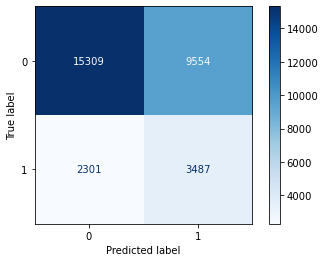

In [11]:
m=logistic_regression_report(X_train_final,X_test_final,y_train_final,y_test_final)

### 6. Feature selection

Utilicen la herramientsa RFECV combinada con una regresión logística para seleccionar el mejor subset de features. Usen una regresión logística con el hiperparámetro de regularización C ajustado en el punto anterior. 

Lo correcto sería optimizar este parámetro para cada subset de features, es decir hacer dos validaciones cruzadas anidadas (una para RFE y otra para la regresión logística), pero por 
economía de cómputo lo haremos con el valor de C fijo.

¿Cuáles features fueron seleccionadas?

¿Cuáles fueron descartadas?

¿Cuál es la performance del modelo?

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle = True)

model = LogisticRegression(C=m.C_[0]) # La penalización óptima podría depender del nro de Features, pero para no sobrecargar el cómputo no optimizaremos C para cada representación de los datos

scaler=StandardScaler()    
X_train_sc=scaler.fit_transform(X_train_final)
X_test_sc=scaler.transform(X_test_final)


selector = RFECV(model, scoring='f1',step = 1, cv=skf, verbose=0,n_jobs=3)
selector.fit(X_train_sc, y_train_final)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
      estimator=LogisticRegression(C=0.000774263682681127), n_jobs=3,
      scoring='f1')

In [13]:
scaler.fit_transform(X_train_final).shape

(74590, 64)

              precision    recall  f1-score   support

           0       0.87      0.61      0.72     24863
           1       0.27      0.60      0.37      5788

    accuracy                           0.61     30651
   macro avg       0.57      0.61      0.54     30651
weighted avg       0.76      0.61      0.65     30651

Area bajo la curva ROC: 0.654
Area bajo la curva Precision-Recall: 0.2931


LogisticRegressionCV(scoring='f1')

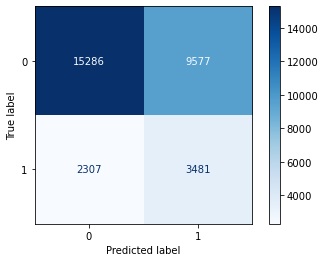

In [14]:
X_train_reduced=X_train_sc[:,selector.support_]
X_test_reduced=X_test_sc[:,selector.support_]
logistic_regression_report(X_train_reduced,X_test_reduced,y_train_final,y_test_final)

In [ ]:
print('Features Conservadas:')
print(X_train_final.columns[selector.support_])

print('\nFeatures Descartadas')
print(X_train_final.columns[~selector.support_])